In [35]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 23.8 MB/s eta 0:00:00


In [69]:
# pylint: disable=unused-import
import os
import random

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torchmetrics import CharErrorRate
from matplotlib import pyplot as plt
from IPython.display import clear_output



In [133]:
def plot_loss(train_loss, val_loss, metrics):
    if len(train_loss) == 0:
        return
    clear_output()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax[0].plot(train_loss, label='train_loss')
    ax[0].plot(val_loss, label='val_loss')
    ax[1].plot(metrics, label='metric')
 
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Metric')    
    ax[0].legend()
    plt.show()

    print(f'train loss {train_loss[-1]:.3f}')
    print(f'val loss {val_loss[-1]:.3f}')
    print(f'metric {metrics[-1]:.3f}')


In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
dataset_dir = '/content/drive/MyDrive/MADE/OCR/dataset'

In [74]:
RANDOM_STATE = 42

In [75]:
images = os.listdir(dataset_dir)
train_images, test_images = train_test_split(images, shuffle=True, train_size=0.75, random_state=RANDOM_STATE)
train_images, val_images = train_test_split(train_images, shuffle=True, train_size=0.8, random_state=RANDOM_STATE)
print('train size:', len(train_images))
print('val size:', len(val_images))
print('test size:', len(test_images))


chars = list(map(lambda x: x[:-4], images))
chars = ''.join(chars)
chars = set(chars)
NUM_CHARS = len(chars)
print('unique chars:', len(chars))

idx2char = {k: v for k, v in enumerate(chars, start=0)}
char2idx = {k: v for v, k in idx2char.items()}

train size: 641
val size: 641
test size: 268
unique chars: 19


### Dataset and DataLoader

In [77]:
class CaptchaDataset(Dataset):
    def __init__(self, images, img_dir=dataset_dir, transform=None):
        self.images = images
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('L')
        label = self.images[idx][:-4]
        label = torch.Tensor([char2idx[char] for char in label])
        if self.transform:
            image = self.transform(image)
        return image, label

In [78]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.25)
        ])

train_dataset = CaptchaDataset(train_images, transform=transform)
val_dataset = CaptchaDataset(val_images, transform=transform)
test_dataset = CaptchaDataset(test_images, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Model

In [81]:
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()
        self.conv_1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn_1 = nn.BatchNorm2d(64)
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv_2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn_2 = nn.BatchNorm2d(128)
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv_3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn_3 = nn.BatchNorm2d(256)
        self.pool_3 = nn.MaxPool2d(kernel_size=(2, 3))

        self.conv_4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn_4 = nn.BatchNorm2d(512)
        self.pool_4 = nn.MaxPool2d(kernel_size=(2, 3))
        
        self.linear_1 = nn.Linear(1536, 64)
        self.lstm = nn.LSTM(64, 32, bidirectional=True, num_layers=2, dropout=0.2, batch_first=True)
        self.linear_2 = nn.Linear(64, NUM_CHARS)


    def forward(self, x):
        # [batch, 1, 50, 200]
        x = self.pool_1(F.relu(self.bn_1(self.conv_1(x))))
        x = F.relu(self.pool_2(self.bn_2(self.conv_2(x))))
        x = F.relu(self.pool_3(self.bn_3(self.conv_3(x))))
        x = self.pool_4(self.bn_4(self.conv_4(x)))  # [batch, 512, 3, 5]

        x = x.permute(0, 3, 1, 2)
        x = x.view(x.shape[0], x.shape[1], -1)
        x = F.relu(self.linear_1(x))
        x, _ = self.lstm(x)
        x = self.linear_2(x)  # [batch, 5, 19]
        return x


if __name__ == "__main__":
    model = OCRModel()
    model.eval()
    x, y = next(iter(train_dataloader))
    preds = model(x)
    print(preds.shape)
    

torch.Size([64, 5, 19])


In [152]:
model = OCRModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
metric = CharErrorRate()


def tensor_to_string(tensor):
    res = ''.join([idx2char[idx] for idx in tensor.cpu().detach().numpy()])
    return res


def acc_fn(preds, labels, return_errors=False):
    errors = []
    result = 0
    for i in range(preds.shape[0]):
        pred = tensor_to_string(preds[i])
        label = tensor_to_string(labels[i])
        res = metric(pred, label)
        result += res
        if return_errors:
            if res != 0:
                errors.append((pred, label))
    if return_errors:
        return result, errors
    return result


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_history = []
    val_history = []
    metric_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.long().to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            preds = preds.permute(0, 2, 1)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.shape[0]      

        model.eval()
        val_loss = 0.0
        acc = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.long().to(device)
                preds = model(inputs)
                preds = preds.permute(0, 2, 1)
                loss = criterion(preds, labels)
                val_loss += loss.item() * inputs.shape[0]
                acc += acc_fn(preds.argmax(1), labels)

        train_history.append(train_loss / len(train_loader.dataset))
        val_history.append(val_loss / len(val_loader.dataset))
        metric_history.append(acc / len(val_loader.dataset))
        plot_loss(train_history, val_history, metric_history)


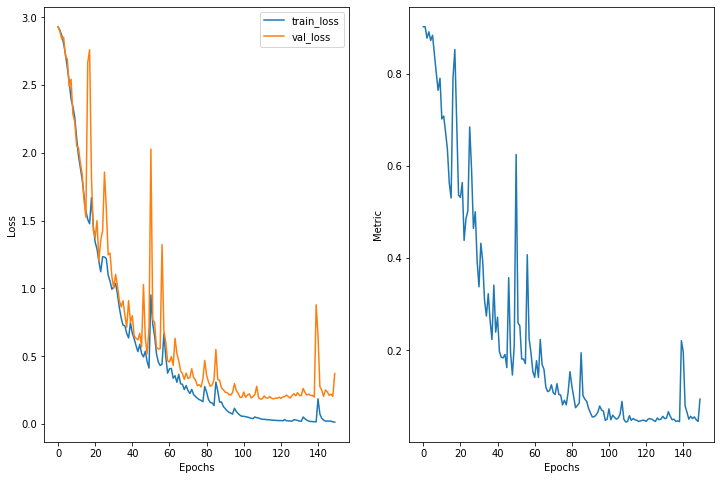

train loss 0.015
val loss 0.372
metric 0.094


In [153]:
train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=130)

In [157]:
def test_model(model, test_loader):
    model.eval()
    acc = 0.0
    errors = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.long().to(device)
            preds = model(inputs)
            res, error = acc_fn(preds.argmax(2), labels, True)
            acc += res
            errors.extend(error)
    return acc / len(test_loader.dataset), errors

Character Error Rate: 0.092


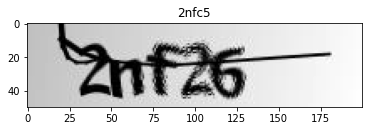

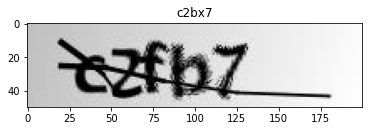

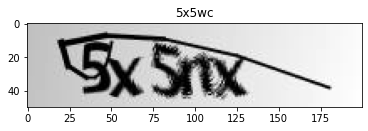

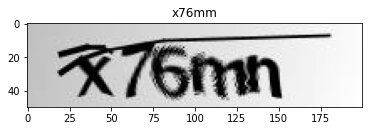

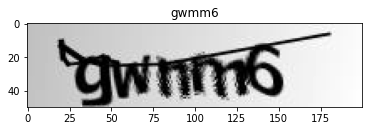

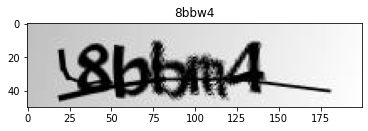

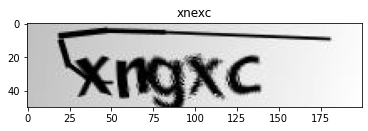

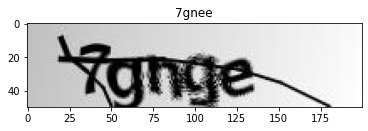

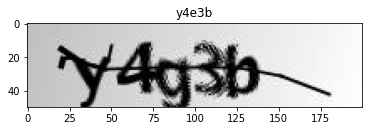

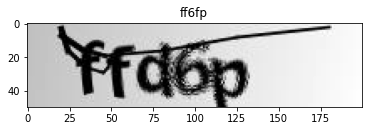

In [172]:
acc, errors = test_model(model, test_dataloader)
print(f'Character Error Rate: {acc:.3f}')
for err in errors[:10]:
    img = dataset_dir + '/' + err[1] + '.png'
    plt.imshow(Image.open(img).convert('L'), cmap='gray')
    plt.title(err[0])
    plt.show()
    print()


In [163]:
err[1]

'xxbm5'